In [ ]:
import joblib
import itertools
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Run ML Experiment

## Prepare Data

In [ ]:
# Load Data 

PROJECT_DIR = Path(os.getcwd()).parent.absolute()
churn_filepath = PROJECT_DIR/'data'/'Churn_Modelling.csv'

In [ ]:
df = pd.read_csv(churn_filepath)
df.head()

In [ ]:
df.shape

In [ ]:
# Are there missing values?
df.isna().sum()

In [ ]:
df['Geography'].value_counts()

In [ ]:
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'


X, y = df[cat_cols + num_cols], df[targ_col]

In [ ]:
y.mean()

In [ ]:
# Data Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Train a model

In [ ]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

# Select algorithm
clf = RandomForestClassifier(random_state=random_state,  **train_params)
# clf = LGBMClassifier(random_state=random_state, **train_params)
# clf = XGBClassifier(random_state=random_state, **train_params)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler())
        ]
    )
categorical_transformer = OrdinalEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", clf)]
    )

model.fit(X_train, y_train)

In [ ]:
# Save model 

joblib.dump(model, PROJECT_DIR/'models/model.joblib')

## Evaluate

In [ ]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, f1_score,
                             roc_auc_score)
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

In [ ]:
# Get predictions 

y_prob = model.predict_proba(X_test)
y_pred = (y_prob[:, 1] >= 0.5).astype(int)

In [ ]:
y_pred

In [ ]:
# Calculate Metrics

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])

print(f1)
print(roc_auc)

In [ ]:
# Plot Confusion Matrix 

cm = confusion_matrix(y_test, y_pred, normalize='true') 
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues) 

# Save image file
plt.savefig(PROJECT_DIR/'results/cm.png')

In [ ]:
# ROC-AUC Curve

# fig, ax = plt.subplots()
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

## Feature Importance

In [ ]:
# Prepare Predictions Table

df_test = X_test.copy(deep=True)
df_test['true'] = y_test
df_test['pred'] = y_pred
df_test['prob'] = y_prob[:, 1]

# Save Predictions
df_test.to_csv(PROJECT_DIR/'results/predictions.csv', index=True)

df_test.head()

In [ ]:
### 2 - Calculcate and save Feature Importance
# Calculate Feature Importance for Train

perm = permutation_importance(
    model, X_train, y_train, n_repeats=3, random_state=0, n_jobs=2)


sorted_importances_idx = perm.importances_mean.argsort()
feat_imp_train = pd.DataFrame(
    perm.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

In [ ]:
ax = feat_imp_train.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
# Feature Importance 

# Prepare Feature Importance Table

fimp_df = (feat_imp_train
 .agg(['mean', 'std'], axis=0)
 .T.sort_values(by='mean', ascending=False)
)

# Save Feature Importance Table
fimp_df.to_csv(PROJECT_DIR/'results/feat_imp_train.csv', index=True)

fimp_df.head()

# DVCLive: Log results of an experiment

## 1 - Log metrics, plots, models and datatsets

Notes:
- `dir` Location of the directory to store outputs (default value is 'dvclive')
- If `dvcyaml=True` (default) and you include any of the fields in `[type, name, desc, labels, meta]`, it will add all the artifact's metadata to the corresponding dvc.yaml.
- Passing `type="model"` will mark it as a model for DVC and will make it appear in Studio model registry.
- Docs: https://dvc.org/doc/dvclive/live/log_artifact 

In [ ]:
from dvclive import Live

with Live(dir=PROJECT_DIR/'results/dvclive',
          dvcyaml=True,
         ) as live:

    # Log metrics
    live.log_metric('f1', f1)
    live.log_metric('roc_auc', roc_auc)

    # Log an existing image
    live.log_image('cm.png', PROJECT_DIR/'results/cm.png')

    # Log Matplotlib Figure as an image
    svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
    live.log_image("roc.png", svc_disp.figure_)

    # Log Model
    live.log_artifact(
        path = PROJECT_DIR/'models/model.joblib',
        type = 'model', 
        cache  = False,  # Version with Git and not cache in DVC storage
        labels = list(fimp_df.index),
        meta = fimp_df.to_dict(orient='index')
    )

    # Log data artifact 
    live.log_artifact(
        path = PROJECT_DIR/'results/feat_imp_train.csv',
        type = 'dataset',
        name = 'feature-importance-train', # custom name of an artifact (use dashes '-' instead of '_' underscores)
        desc = 'Permutation based Feature Importance for Train dataset',
        labels = ['train'],
        meta = {'n_repeats': 3},
        copy  = False,
        cache  = True, # Version with DVC - store in DVC cache/storage
    )

## 2 - Commit results with Git and DVC

- Follow README instructions to set up DVC `local` storage to follow the example
- Documentation on [DVC Remote Storage](https://dvc.org/doc/user-guide/data-management/remote-storage#remote-storage)

In [ ]:
!git add ../      # Commit experiment to Git
!git commit -m "my-first-experiment"
!git push         # Push changes to Git remote

In [ ]:
# !dvc push -r local               # Push DVC tracking artifacts to DVC remote storage 

# DVCLive: Monitor your experimetns in Live mode with DVCLive and Studio

## 1 - Connect Studio DVCLive

Note: 
- Create Studio access token and set up DVC: https://dvc.org/doc/studio/user-guide/projects-and-experiments/live-metrics-and-plots#set-up-an-access-token

- 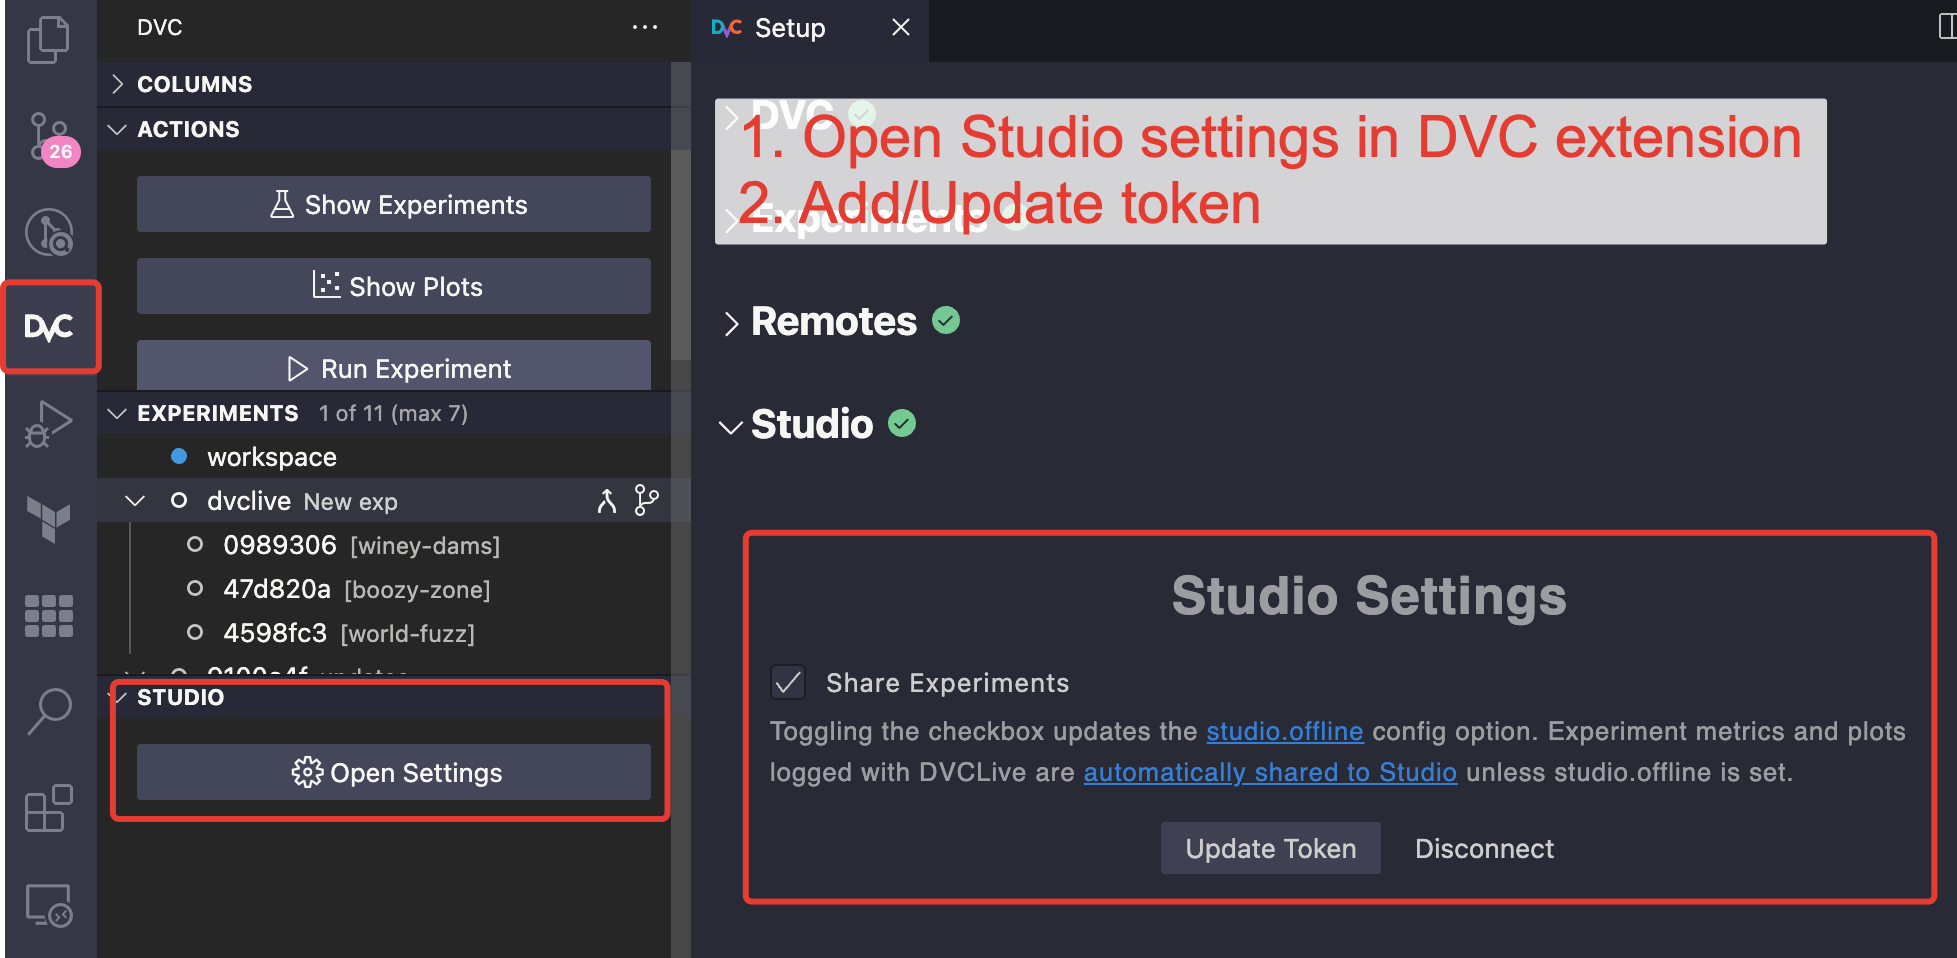

In [ ]:
# ! dvc config --global studio.token ***

## 2 - Run ML training with several steps/epochs

In [ ]:
# Run multiple experiments for parameters combination 
params = {
    'n_estimators': [10, 20, 30, 50],     
    'max_depth': [3, 6, 12, 24]
}

with Live(dir=PROJECT_DIR/'results/gridsearch',
          save_dvc_exp=True,  # DVCLive will create a new DVC experiment 
          dvcyaml=True,
          report='notebook',  # Display a report in the Notebook
         ) as live:
    
    # Iterate over parameters, folds or epocs
    for _params in list(itertools.product(params['n_estimators'], params['max_depth'])):

        # Get params to train
        train_params = {
            'n_estimators': _params[0], 
            'max_depth': _params[1]
        }

        # Train a model
        xgb = XGBClassifier(random_state=random_state, **train_params)
        model_xgb = Pipeline(steps=[("preprocessor", preprocessor), ("clf", xgb)])
        model_xgb.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model_xgb.predict(X_test)
        y_prob = model_xgb.predict_proba(X_test)

        # Calculate metrics 
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])

        # Log metrics
        live.log_metric('f1', f1)
        live.log_metric('roc_auc', roc_auc)

        # Signal that the current iteration has ended and increases step value by 1 (one).
        live.next_step()



## 3 - Commit results with Git and DVC

- Follow README instructions to set up DVC `local` storage to follow the example
- Documentation on [DVC Remote Storage](https://dvc.org/doc/user-guide/data-management/remote-storage#remote-storage)